# Лабораторная работа 1. Глубокое обучение

In [ ]:
pip install jupyterlab torch torchvision matplotlib numpy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from torch.optim.lr_scheduler import CyclicLR

## Часть 1: Введение в сверточные нейронные сети (CNN) для классификации изображений

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
test_losses = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f"Эпоха {epoch+1}/{num_epochs}, Потеря на обучении: {train_losses[-1]:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Точность на тестовом наборе: {accuracy:.2f}%")

Эпоха 1/10, Потеря на обучении: 1.4391
Точность на тестовом наборе: 62.08%
Эпоха 2/10, Потеря на обучении: 1.1000
Точность на тестовом наборе: 68.07%
Эпоха 3/10, Потеря на обучении: 0.9660
Точность на тестовом наборе: 69.24%
Эпоха 4/10, Потеря на обучении: 0.8800
Точность на тестовом наборе: 71.81%
Эпоха 5/10, Потеря на обучении: 0.8080
Точность на тестовом наборе: 70.99%
Эпоха 6/10, Потеря на обучении: 0.7430
Точность на тестовом наборе: 72.13%
Эпоха 7/10, Потеря на обучении: 0.6911
Точность на тестовом наборе: 73.57%
Эпоха 8/10, Потеря на обучении: 0.6398
Точность на тестовом наборе: 74.09%
Эпоха 9/10, Потеря на обучении: 0.6011
Точность на тестовом наборе: 74.21%
Эпоха 10/10, Потеря на обучении: 0.5668
Точность на тестовом наборе: 73.84%


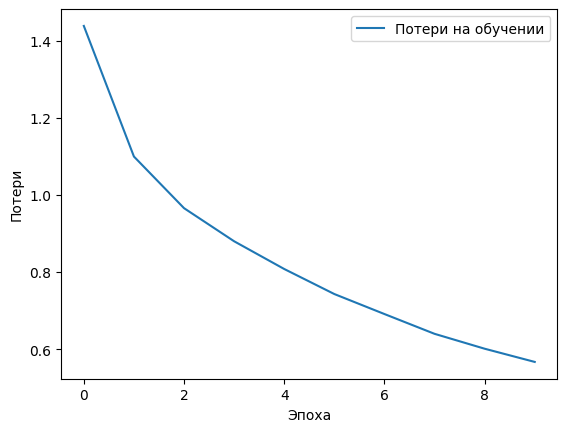

In [ ]:
plt.plot(train_losses, label='Потери на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.show()

## Часть 2: Классификация изображений с предобработкой и аугментацией данных

Тестирование на датасете cifar с трансформациями

In [ ]:
transform_sets = {
    'basic': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ]),
    'augmented_cifar': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ])
}

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    loss_total = 0.0
    correct, total = 0, 0
    y_true, y_pred, y_proba = [], [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item() * images.size(0)

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_proba.extend(probs.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = loss_total / total
    acc = 100 * correct / total
    return avg_loss, acc, np.array(y_true), np.array(y_pred), np.array(y_proba)

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss, title=''):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def train_on_cifar(transform_name, num_epochs=10, batch_size=64, lr=0.001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    print(f"\n=== CIFAR-10 | Трансформация: {transform_name} ===")

    transform = transform_sets[transform_name]

    train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=transform_sets['basic'])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        test_loss, test_acc, y_true, y_pred, y_proba = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Эпоха {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr')
    except:
        roc_auc = float('nan')

    print(f"\n Метрики для CIFAR-10 | {transform_name}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    plot_metrics(train_accs, test_accs, train_losses, test_losses, title=f'CIFAR-10 | {transform_name}')


=== CIFAR-10 | Трансформация: basic ===
Эпоха 1/10 | Train Loss: 1.3813 | Train Acc: 50.75% | Test Acc: 61.86%
Эпоха 2/10 | Train Loss: 1.0594 | Train Acc: 62.49% | Test Acc: 68.58%
Эпоха 3/10 | Train Loss: 0.9260 | Train Acc: 67.59% | Test Acc: 69.48%
Эпоха 4/10 | Train Loss: 0.8328 | Train Acc: 70.78% | Test Acc: 71.78%
Эпоха 5/10 | Train Loss: 0.7617 | Train Acc: 73.27% | Test Acc: 72.10%
Эпоха 6/10 | Train Loss: 0.6929 | Train Acc: 75.57% | Test Acc: 73.22%
Эпоха 7/10 | Train Loss: 0.6370 | Train Acc: 77.44% | Test Acc: 72.03%
Эпоха 8/10 | Train Loss: 0.5946 | Train Acc: 78.85% | Test Acc: 73.29%
Эпоха 9/10 | Train Loss: 0.5535 | Train Acc: 80.27% | Test Acc: 73.85%
Эпоха 10/10 | Train Loss: 0.5073 | Train Acc: 81.84% | Test Acc: 73.98%

 Метрики для CIFAR-10 | basic
Precision: 0.7393
Recall:    0.7398
F1-Score:  0.7377
ROC-AUC:   0.9640


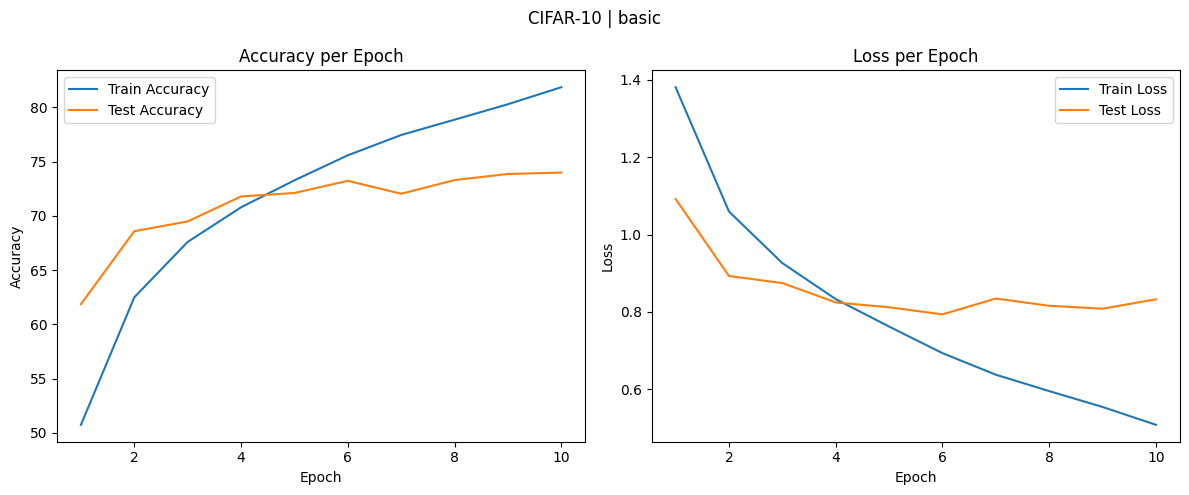


=== CIFAR-10 | Трансформация: augmented_cifar ===
Эпоха 1/10 | Train Loss: 1.6426 | Train Acc: 40.39% | Test Acc: 56.24%
Эпоха 2/10 | Train Loss: 1.3469 | Train Acc: 51.37% | Test Acc: 63.77%
Эпоха 3/10 | Train Loss: 1.2289 | Train Acc: 56.65% | Test Acc: 65.47%
Эпоха 4/10 | Train Loss: 1.1534 | Train Acc: 59.08% | Test Acc: 67.42%
Эпоха 5/10 | Train Loss: 1.0992 | Train Acc: 61.37% | Test Acc: 67.72%
Эпоха 6/10 | Train Loss: 1.0667 | Train Acc: 62.42% | Test Acc: 71.60%
Эпоха 7/10 | Train Loss: 1.0364 | Train Acc: 63.69% | Test Acc: 70.97%
Эпоха 8/10 | Train Loss: 1.0023 | Train Acc: 64.85% | Test Acc: 71.25%
Эпоха 9/10 | Train Loss: 0.9879 | Train Acc: 65.44% | Test Acc: 72.12%
Эпоха 10/10 | Train Loss: 0.9648 | Train Acc: 66.35% | Test Acc: 73.15%

 Метрики для CIFAR-10 | augmented_cifar
Precision: 0.7401
Recall:    0.7315
F1-Score:  0.7302
ROC-AUC:   0.9638


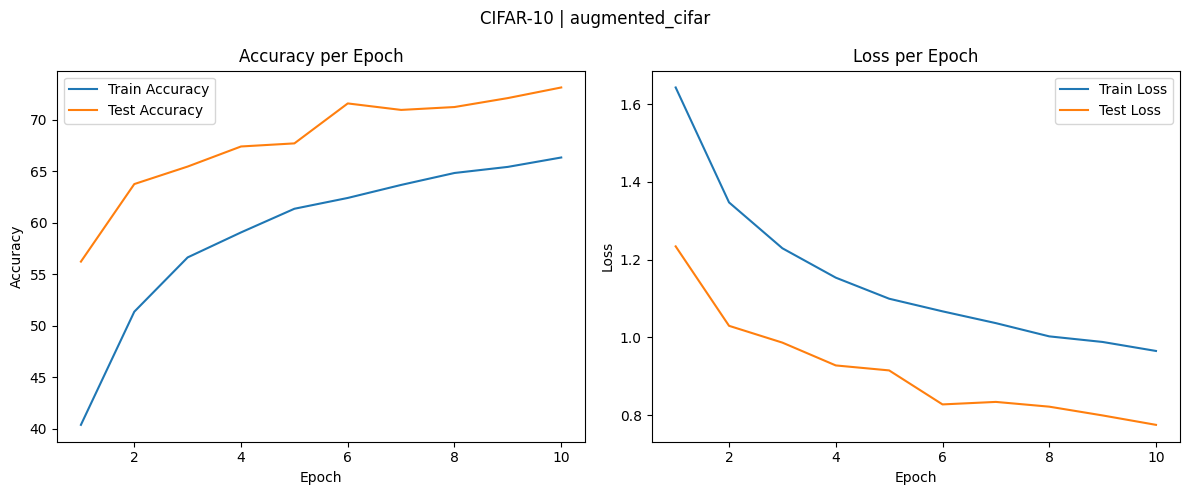

In [ ]:
train_on_cifar('basic', num_epochs=10)
train_on_cifar('augmented_cifar', num_epochs=10)

Тестирование на датасете FashionMNIST с трансформациями

In [ ]:
transform_sets = {
    'basic': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    'augmented_fmnist': transforms.Compose([
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
}

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    loss_total = 0.0
    correct, total = 0, 0
    y_true, y_pred, y_proba = [], [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item() * images.size(0)

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_proba.extend(probs.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = loss_total / total
    acc = 100 * correct / total
    return avg_loss, acc, np.array(y_true), np.array(y_pred), np.array(y_proba)

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss, title=''):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def train_on_fashionmnist(transform_name, num_epochs=10, batch_size=64, lr=0.001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    print(f"\n=== FashionMNIST | Трансформация: {transform_name} ===")

    transform = transform_sets[transform_name]

    train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform_sets['basic'])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        test_loss, test_acc, y_true, y_pred, y_proba = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Эпоха {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr')
    except:
        roc_auc = float('nan')

    print(f"\n Метрики для FashionMNIST | {transform_name}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    plot_metrics(train_accs, test_accs, train_losses, test_losses, title=f'FashionMNIST | {transform_name}')


=== FashionMNIST | Трансформация: basic ===
Эпоха 1/10 | Train Loss: 0.4501 | Train Acc: 83.97% | Test Acc: 87.72%
Эпоха 2/10 | Train Loss: 0.3162 | Train Acc: 88.69% | Test Acc: 89.36%
Эпоха 3/10 | Train Loss: 0.2765 | Train Acc: 89.89% | Test Acc: 91.10%
Эпоха 4/10 | Train Loss: 0.2493 | Train Acc: 91.03% | Test Acc: 91.00%
Эпоха 5/10 | Train Loss: 0.2313 | Train Acc: 91.56% | Test Acc: 91.38%
Эпоха 6/10 | Train Loss: 0.2121 | Train Acc: 92.25% | Test Acc: 91.67%
Эпоха 7/10 | Train Loss: 0.1993 | Train Acc: 92.61% | Test Acc: 91.72%
Эпоха 8/10 | Train Loss: 0.1881 | Train Acc: 93.12% | Test Acc: 92.28%
Эпоха 9/10 | Train Loss: 0.1759 | Train Acc: 93.48% | Test Acc: 91.96%
Эпоха 10/10 | Train Loss: 0.1630 | Train Acc: 93.91% | Test Acc: 91.69%

 Метрики для FashionMNIST | basic
Precision: 0.9173
Recall:    0.9169
F1-Score:  0.9159
ROC-AUC:   0.9950


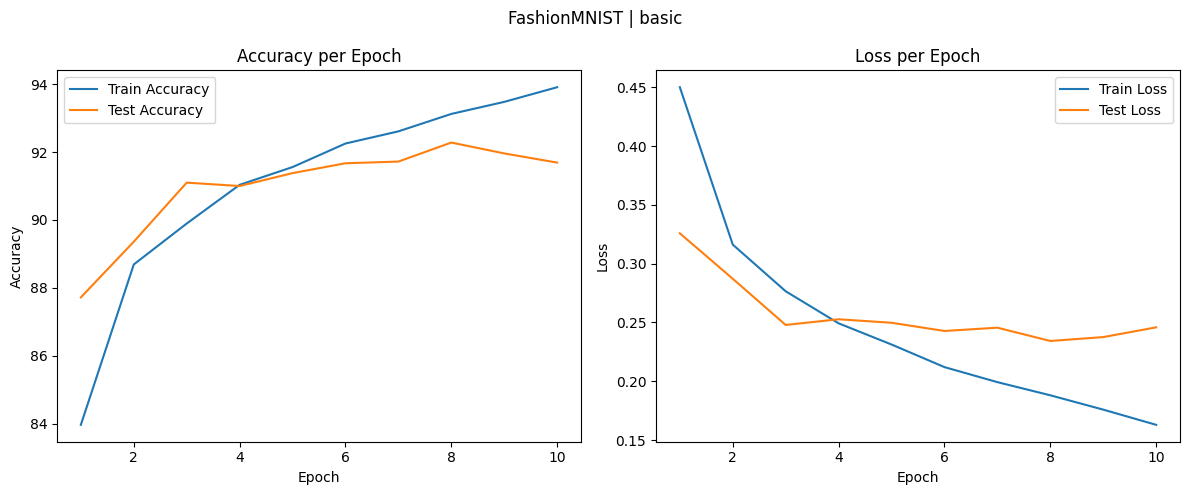


=== FashionMNIST | Трансформация: augmented_fmnist ===
Эпоха 1/10 | Train Loss: 0.5148 | Train Acc: 81.21% | Test Acc: 87.07%
Эпоха 2/10 | Train Loss: 0.3745 | Train Acc: 86.44% | Test Acc: 89.32%
Эпоха 3/10 | Train Loss: 0.3387 | Train Acc: 87.90% | Test Acc: 89.93%
Эпоха 4/10 | Train Loss: 0.3115 | Train Acc: 88.58% | Test Acc: 89.79%
Эпоха 5/10 | Train Loss: 0.2918 | Train Acc: 89.42% | Test Acc: 90.24%
Эпоха 6/10 | Train Loss: 0.2808 | Train Acc: 89.77% | Test Acc: 90.71%
Эпоха 7/10 | Train Loss: 0.2714 | Train Acc: 90.30% | Test Acc: 91.23%
Эпоха 8/10 | Train Loss: 0.2635 | Train Acc: 90.46% | Test Acc: 91.07%
Эпоха 9/10 | Train Loss: 0.2573 | Train Acc: 90.73% | Test Acc: 91.49%
Эпоха 10/10 | Train Loss: 0.2454 | Train Acc: 91.17% | Test Acc: 91.46%

 Метрики для FashionMNIST | augmented_fmnist
Precision: 0.9142
Recall:    0.9146
F1-Score:  0.9141
ROC-AUC:   0.9949


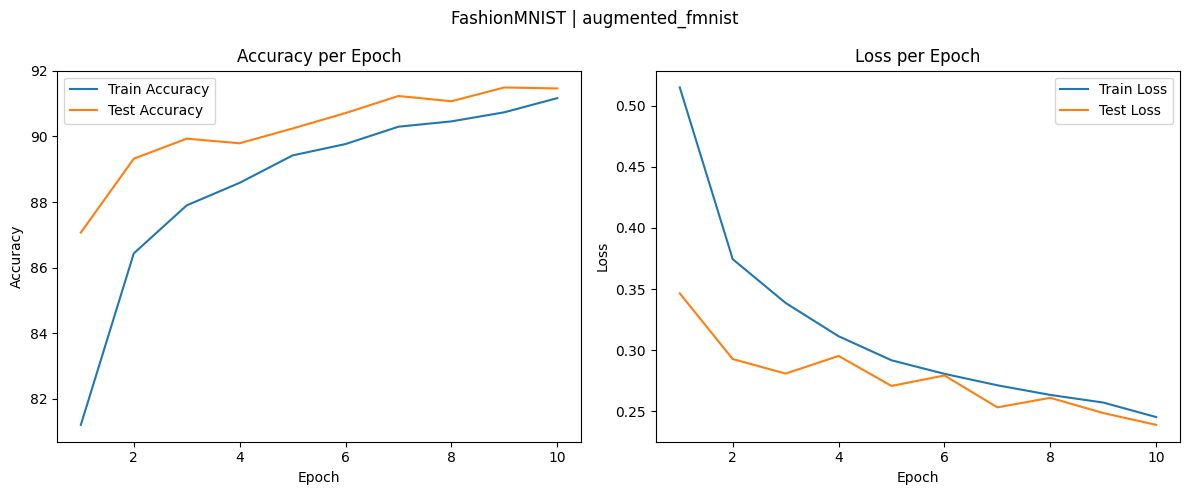

In [ ]:
train_on_fashionmnist('basic', num_epochs=10)
train_on_fashionmnist('augmented_fmnist', num_epochs=10)

Тестирование на датасете SVHN с трансформациями

In [ ]:
transform_sets = {
    'basic': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3)
    ]),
    'augmented_svhn': transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3)
    ])
}

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    loss_total = 0.0
    correct, total = 0, 0
    y_true, y_pred, y_proba = [], [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item() * images.size(0)

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_proba.extend(probs.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = loss_total / total
    acc = 100 * correct / total
    return avg_loss, acc, np.array(y_true), np.array(y_pred), np.array(y_proba)

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss, title=''):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def train_on_svhn(transform_name, num_epochs=10, batch_size=64, lr=0.001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    print(f"\n=== SVHN | Трансформация: {transform_name} ===")

    transform = transform_sets[transform_name]

    train_dataset = datasets.SVHN(root='data', split='train', download=True, transform=transform)
    test_dataset = datasets.SVHN(root='data', split='test', download=True, transform=transform_sets['basic'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        test_loss, test_acc, y_true, y_pred, y_proba = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Эпоха {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr')
    except:
        roc_auc = float('nan')

    print(f"\n Метрики для SVHN | {transform_name}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    plot_metrics(train_accs, test_accs, train_losses, test_losses, title=f'SVHN | {transform_name}')


=== SVHN | Трансформация: basic ===


100%|██████████| 64.3M/64.3M [00:07<00:00, 8.45MB/s]


Эпоха 1/10 | Train Loss: 0.8276 | Train Acc: 73.23% | Test Acc: 85.93%
Эпоха 2/10 | Train Loss: 0.4836 | Train Acc: 85.42% | Test Acc: 86.66%
Эпоха 3/10 | Train Loss: 0.4280 | Train Acc: 86.95% | Test Acc: 88.58%
Эпоха 4/10 | Train Loss: 0.3792 | Train Acc: 88.41% | Test Acc: 89.15%
Эпоха 5/10 | Train Loss: 0.3494 | Train Acc: 89.31% | Test Acc: 89.20%
Эпоха 6/10 | Train Loss: 0.3264 | Train Acc: 89.97% | Test Acc: 89.41%
Эпоха 7/10 | Train Loss: 0.3033 | Train Acc: 90.61% | Test Acc: 89.88%
Эпоха 8/10 | Train Loss: 0.2887 | Train Acc: 90.99% | Test Acc: 89.82%
Эпоха 9/10 | Train Loss: 0.2746 | Train Acc: 91.38% | Test Acc: 89.59%
Эпоха 10/10 | Train Loss: 0.2578 | Train Acc: 91.92% | Test Acc: 89.86%

 Метрики для SVHN | basic
Precision: 0.8987
Recall:    0.8986
F1-Score:  0.8983
ROC-AUC:   0.9908


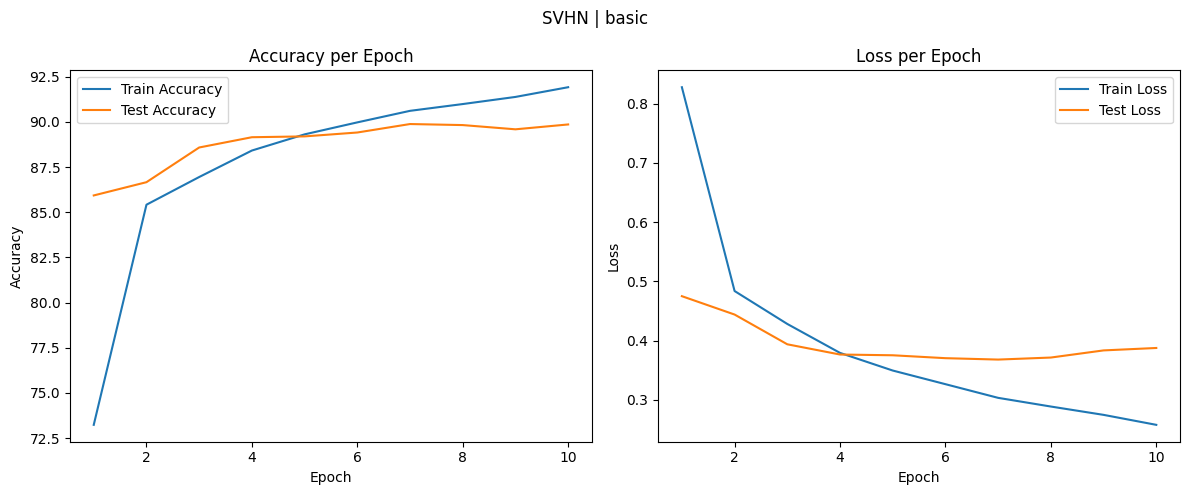


=== SVHN | Трансформация: augmented_svhn ===
Эпоха 1/10 | Train Loss: 1.2023 | Train Acc: 58.80% | Test Acc: 79.56%
Эпоха 2/10 | Train Loss: 0.7234 | Train Acc: 77.12% | Test Acc: 83.07%
Эпоха 3/10 | Train Loss: 0.6241 | Train Acc: 80.54% | Test Acc: 82.85%
Эпоха 4/10 | Train Loss: 0.5831 | Train Acc: 81.69% | Test Acc: 84.33%
Эпоха 5/10 | Train Loss: 0.5473 | Train Acc: 82.85% | Test Acc: 85.41%
Эпоха 6/10 | Train Loss: 0.5178 | Train Acc: 83.66% | Test Acc: 85.89%
Эпоха 7/10 | Train Loss: 0.4927 | Train Acc: 84.66% | Test Acc: 86.61%
Эпоха 8/10 | Train Loss: 0.4780 | Train Acc: 85.08% | Test Acc: 87.05%
Эпоха 9/10 | Train Loss: 0.4605 | Train Acc: 85.76% | Test Acc: 87.76%
Эпоха 10/10 | Train Loss: 0.4533 | Train Acc: 85.72% | Test Acc: 86.62%

 Метрики для SVHN | augmented_svhn
Precision: 0.8682
Recall:    0.8662
F1-Score:  0.8665
ROC-AUC:   0.9877


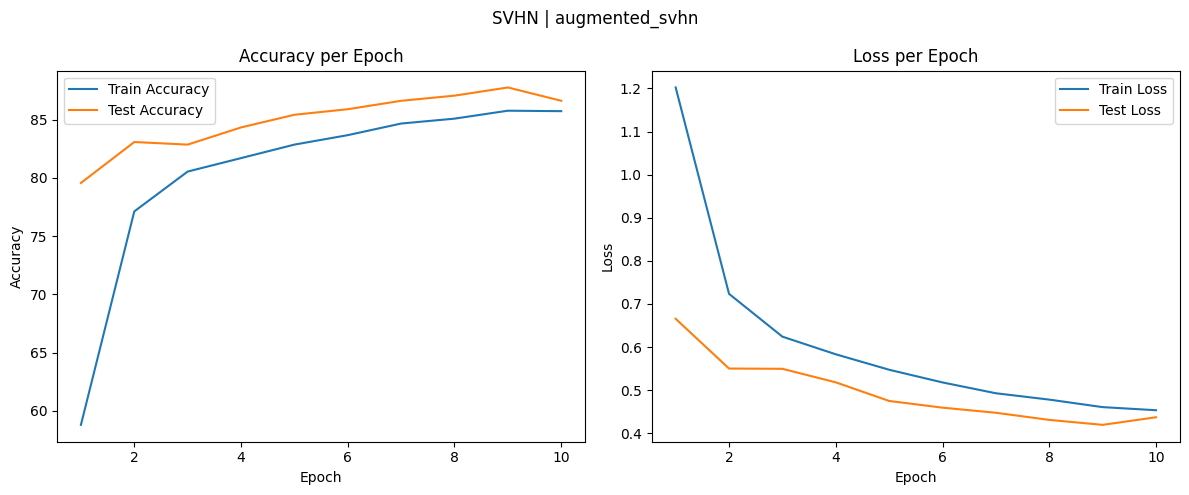

In [ ]:
train_on_svhn('basic', num_epochs=10)
train_on_svhn('augmented_svhn', num_epochs=10)

## Часть 3: Оптимизация архитектуры CNN

### 1. Количество и размер сверточных фильтров

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, channels=(32, 64), kernels=(3, 3)):
        super(CustomCNN, self).__init__()
        self.single_layer = len(channels) == 1

        if self.single_layer:
            c1 = channels[0]
            k1 = kernels[0]
            self.conv1 = nn.Conv2d(3, c1, kernel_size=k1, padding=k1 // 2)
            self.pool = nn.MaxPool2d(2, 2)
            self.fc1 = nn.Linear(c1 * 16 * 16, 128)
        else:
            c1, c2 = channels
            k1, k2 = kernels
            self.conv1 = nn.Conv2d(3, c1, kernel_size=k1, padding=k1 // 2)
            self.conv2 = nn.Conv2d(c1, c2, kernel_size=k2, padding=k2 // 2)
            self.pool = nn.MaxPool2d(2, 2)
            self.batch_norm = nn.BatchNorm2d(c2)
            self.fc1 = nn.Linear(c2 * 8 * 8, 128)

        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        if self.single_layer:
            x = self.pool(torch.relu(self.conv1(x)))
        else:
            x = self.pool(torch.relu(self.conv1(x)))
            x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

def create_model(channels=(32, 64), kernels=(3, 3)):
    return CustomCNN(channels=channels, kernels=kernels)

In [ ]:
def train_model(model, num_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        print(f"Эпоха {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies

In [ ]:
experiments = {
    "16-32 (3x3,5x5)": ((16, 32), (3, 5)),
    "64-128 (3x3,5x5)": ((64, 128), (3, 5)),
    "256 (7x7)": ((256,), (7,))
}

results = {}

for name, (channels, kernels) in experiments.items():
    print(f"\n==== Обучение модели: {name} ====")
    model = create_model(channels=channels, kernels=kernels)
    train_losses, test_accuracies = train_model(model, num_epochs=10)
    results[name] = (train_losses, test_accuracies)


==== Обучение модели: 16-32 (3x3,5x5) ====
Эпоха 1/10 | Loss: 1.4288 | Accuracy: 59.11%
Эпоха 2/10 | Loss: 1.1078 | Accuracy: 65.33%
Эпоха 3/10 | Loss: 0.9729 | Accuracy: 69.09%
Эпоха 4/10 | Loss: 0.8857 | Accuracy: 69.20%
Эпоха 5/10 | Loss: 0.8228 | Accuracy: 71.32%
Эпоха 6/10 | Loss: 0.7653 | Accuracy: 71.04%
Эпоха 7/10 | Loss: 0.7217 | Accuracy: 71.58%
Эпоха 8/10 | Loss: 0.6804 | Accuracy: 72.46%
Эпоха 9/10 | Loss: 0.6409 | Accuracy: 72.60%
Эпоха 10/10 | Loss: 0.6130 | Accuracy: 72.27%

==== Обучение модели: 64-128 (3x3,5x5) ====
Эпоха 1/10 | Loss: 1.4846 | Accuracy: 59.48%
Эпоха 2/10 | Loss: 1.1038 | Accuracy: 67.66%
Эпоха 3/10 | Loss: 0.9285 | Accuracy: 69.75%
Эпоха 4/10 | Loss: 0.8253 | Accuracy: 73.33%
Эпоха 5/10 | Loss: 0.7356 | Accuracy: 74.07%
Эпоха 6/10 | Loss: 0.6626 | Accuracy: 74.32%
Эпоха 7/10 | Loss: 0.6014 | Accuracy: 74.81%
Эпоха 8/10 | Loss: 0.5441 | Accuracy: 75.94%
Эпоха 9/10 | Loss: 0.5073 | Accuracy: 75.64%
Эпоха 10/10 | Loss: 0.4672 | Accuracy: 76.24%

==== Обу

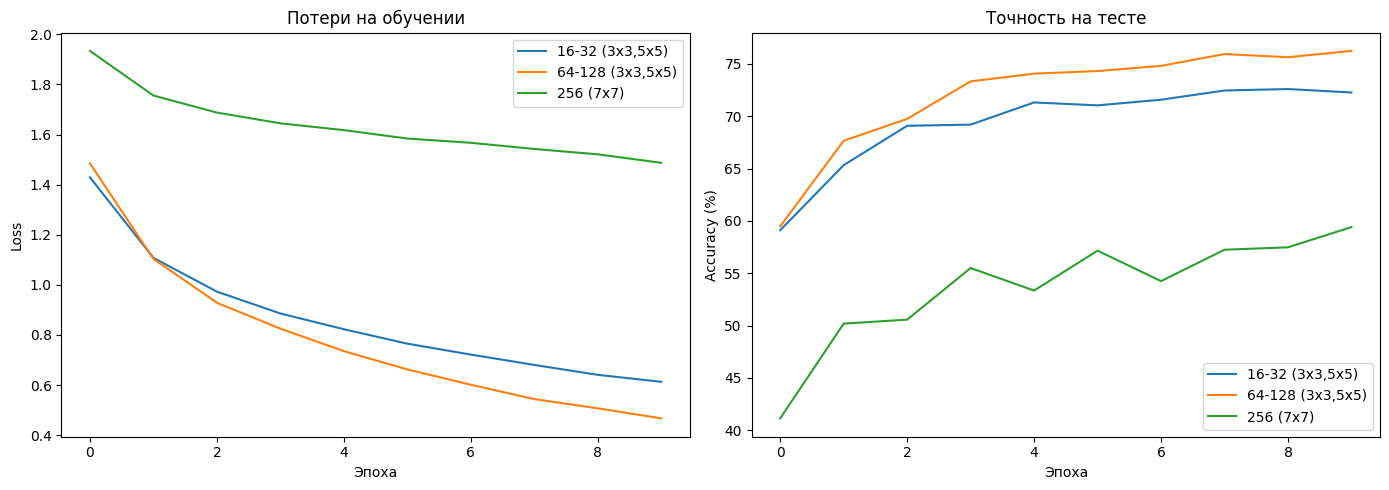

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for name, (train_losses, _) in results.items():
    plt.plot(train_losses, label=name)
plt.title('Потери на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()

plt.subplot(1, 2, 2)
for name, (_, test_accuracies) in results.items():
    plt.plot(test_accuracies, label=name)
plt.title('Точность на тесте')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

### 2. Пулинг (Pooling) слои

пример 1

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
test_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Эпоха {epoch+1}/{num_epochs}, Потеря на обучении: {train_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Точность на тестовом наборе: {accuracy:.2f}%")

Эпоха 1/10, Потеря на обучении: 1.4378
Точность на тестовом наборе: 62.35%
Эпоха 2/10, Потеря на обучении: 1.0925
Точность на тестовом наборе: 66.62%
Эпоха 3/10, Потеря на обучении: 0.9585
Точность на тестовом наборе: 70.33%
Эпоха 4/10, Потеря на обучении: 0.8625
Точность на тестовом наборе: 70.65%
Эпоха 5/10, Потеря на обучении: 0.7945
Точность на тестовом наборе: 71.68%
Эпоха 6/10, Потеря на обучении: 0.7279
Точность на тестовом наборе: 73.03%
Эпоха 7/10, Потеря на обучении: 0.6696
Точность на тестовом наборе: 73.01%
Эпоха 8/10, Потеря на обучении: 0.6298
Точность на тестовом наборе: 74.10%
Эпоха 9/10, Потеря на обучении: 0.5844
Точность на тестовом наборе: 73.54%
Эпоха 10/10, Потеря на обучении: 0.5459
Точность на тестовом наборе: 74.25%


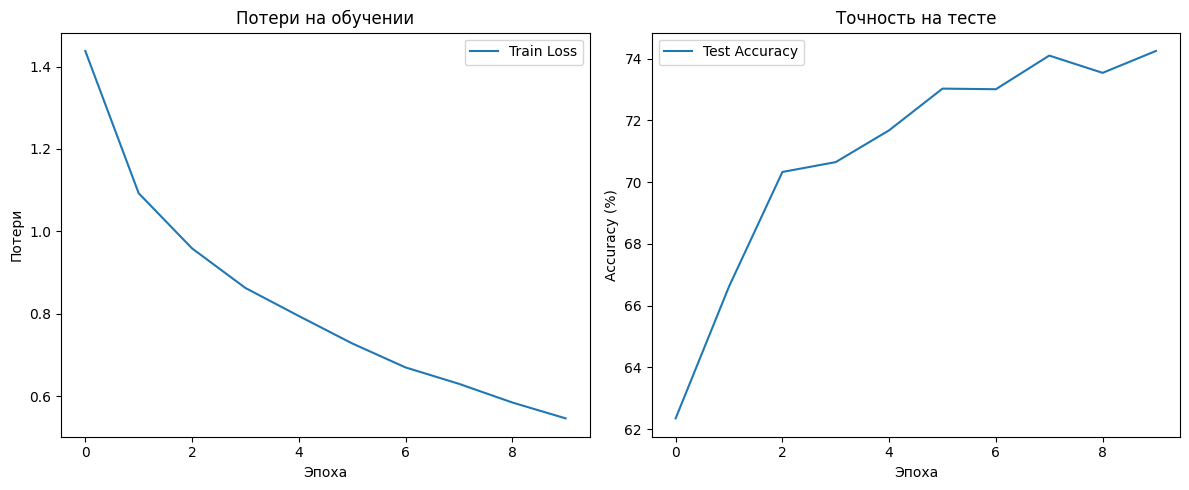

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Потери на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Точность на тесте')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

пример 2

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 3 * 3)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
test_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Эпоха {epoch+1}/{num_epochs}, Потеря на обучении: {train_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Точность на тестовом наборе: {accuracy:.2f}%")

Эпоха 1/10, Потеря на обучении: 1.4553
Точность на тестовом наборе: 61.93%
Эпоха 2/10, Потеря на обучении: 1.1178
Точность на тестовом наборе: 66.52%
Эпоха 3/10, Потеря на обучении: 1.0003
Точность на тестовом наборе: 68.18%
Эпоха 4/10, Потеря на обучении: 0.9246
Точность на тестовом наборе: 70.84%
Эпоха 5/10, Потеря на обучении: 0.8812
Точность на тестовом наборе: 71.35%
Эпоха 6/10, Потеря на обучении: 0.8331
Точность на тестовом наборе: 72.44%
Эпоха 7/10, Потеря на обучении: 0.8057
Точность на тестовом наборе: 73.39%
Эпоха 8/10, Потеря на обучении: 0.7764
Точность на тестовом наборе: 73.08%
Эпоха 9/10, Потеря на обучении: 0.7563
Точность на тестовом наборе: 72.71%
Эпоха 10/10, Потеря на обучении: 0.7352
Точность на тестовом наборе: 73.71%


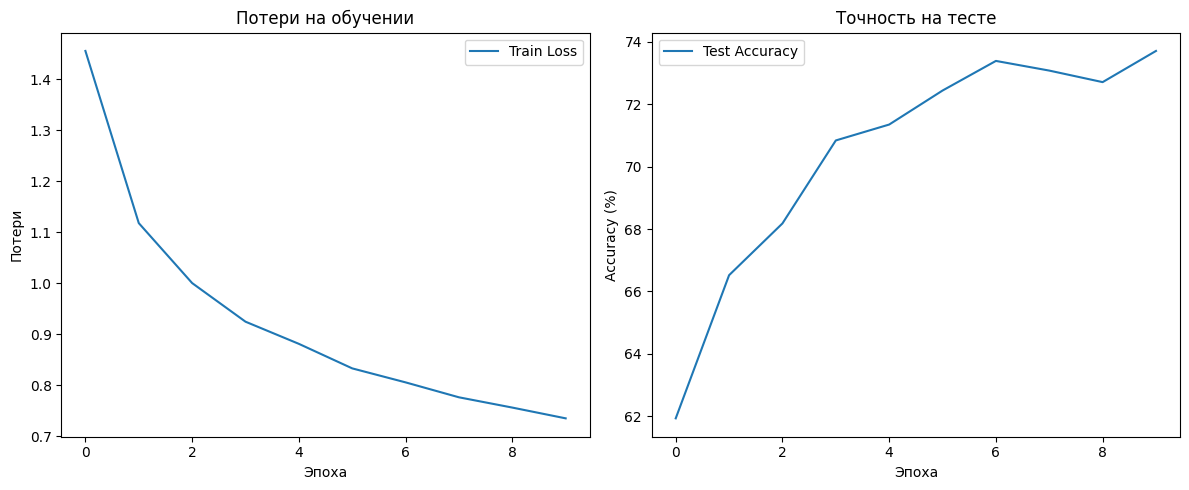

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Потери на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Точность на тесте')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

пример 3

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
test_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Эпоха {epoch+1}/{num_epochs}, Потеря на обучении: {train_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Точность на тестовом наборе: {accuracy:.2f}%")

Эпоха 1/10, Потеря на обучении: 1.3705
Точность на тестовом наборе: 63.58%
Эпоха 2/10, Потеря на обучении: 1.0414
Точность на тестовом наборе: 67.98%
Эпоха 3/10, Потеря на обучении: 0.8984
Точность на тестовом наборе: 70.61%
Эпоха 4/10, Потеря на обучении: 0.7945
Точность на тестовом наборе: 71.52%
Эпоха 5/10, Потеря на обучении: 0.7210
Точность на тестовом наборе: 71.90%
Эпоха 6/10, Потеря на обучении: 0.6575
Точность на тестовом наборе: 72.38%
Эпоха 7/10, Потеря на обучении: 0.6077
Точность на тестовом наборе: 72.48%
Эпоха 8/10, Потеря на обучении: 0.5593
Точность на тестовом наборе: 73.52%
Эпоха 9/10, Потеря на обучении: 0.5203
Точность на тестовом наборе: 72.94%
Эпоха 10/10, Потеря на обучении: 0.4846
Точность на тестовом наборе: 72.50%


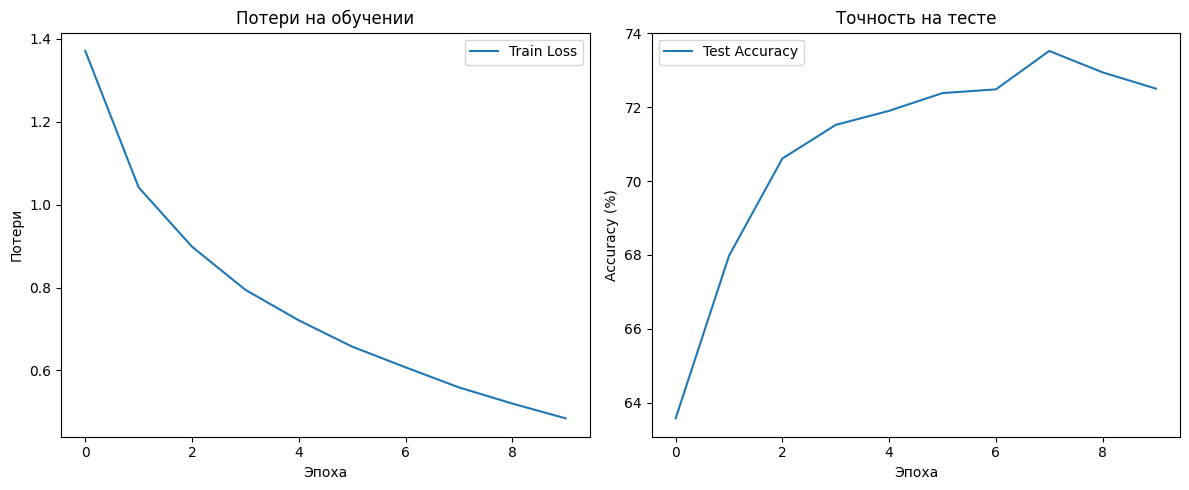

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Потери на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Точность на тесте')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

### 3. Batch Normalization

пример 1

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool(self.bn2(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
test_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Эпоха {epoch+1}/{num_epochs}, Потеря на обучении: {epoch_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    test_accuracies.append(epoch_accuracy)
    print(f"Точность на тестовом наборе: {epoch_accuracy:.2f}%")

Эпоха 1/10, Потеря на обучении: 1.3905
Точность на тестовом наборе: 63.07%
Эпоха 2/10, Потеря на обучении: 1.0992
Точность на тестовом наборе: 67.74%
Эпоха 3/10, Потеря на обучении: 0.9642
Точность на тестовом наборе: 71.17%
Эпоха 4/10, Потеря на обучении: 0.8706
Точность на тестовом наборе: 72.14%
Эпоха 5/10, Потеря на обучении: 0.7897
Точность на тестовом наборе: 73.34%
Эпоха 6/10, Потеря на обучении: 0.7284
Точность на тестовом наборе: 73.31%
Эпоха 7/10, Потеря на обучении: 0.6720
Точность на тестовом наборе: 73.86%
Эпоха 8/10, Потеря на обучении: 0.6246
Точность на тестовом наборе: 74.36%
Эпоха 9/10, Потеря на обучении: 0.5868
Точность на тестовом наборе: 75.07%
Эпоха 10/10, Потеря на обучении: 0.5477
Точность на тестовом наборе: 74.52%


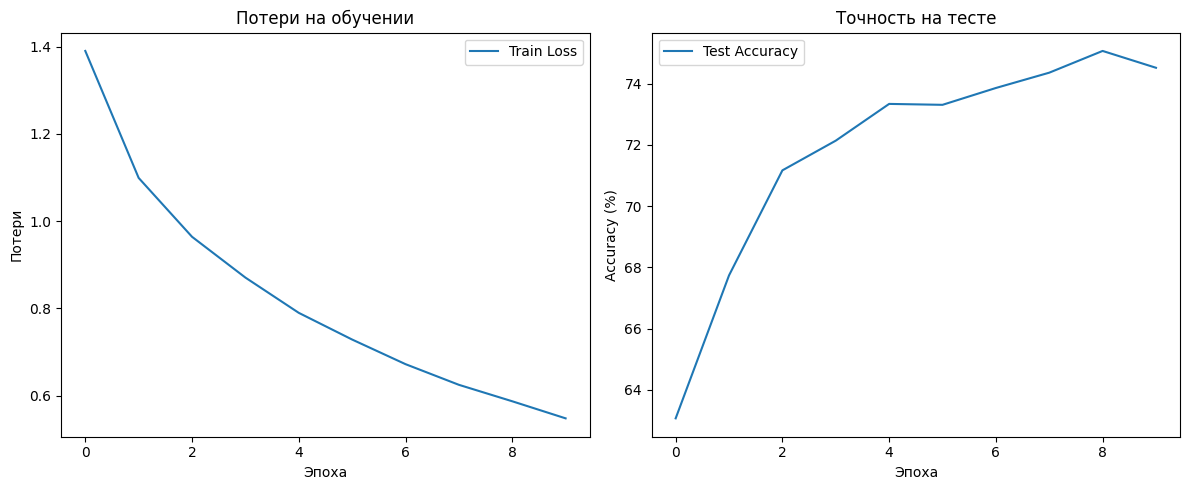

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Потери на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Точность на тесте')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

пример 2

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(self.bn3(torch.relu(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
test_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Эпоха {epoch+1}/{num_epochs}, Потеря на обучении: {epoch_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    test_accuracies.append(epoch_accuracy)
    print(f"Точность на тестовом наборе: {epoch_accuracy:.2f}%")

Эпоха 1/10, Потеря на обучении: 1.3805
Точность на тестовом наборе: 65.15%
Эпоха 2/10, Потеря на обучении: 1.0096
Точность на тестовом наборе: 70.69%
Эпоха 3/10, Потеря на обучении: 0.8743
Точность на тестовом наборе: 72.65%
Эпоха 4/10, Потеря на обучении: 0.7773
Точность на тестовом наборе: 73.72%
Эпоха 5/10, Потеря на обучении: 0.7120
Точность на тестовом наборе: 75.49%
Эпоха 6/10, Потеря на обучении: 0.6461
Точность на тестовом наборе: 76.97%
Эпоха 7/10, Потеря на обучении: 0.5957
Точность на тестовом наборе: 76.60%
Эпоха 8/10, Потеря на обучении: 0.5527
Точность на тестовом наборе: 77.00%
Эпоха 9/10, Потеря на обучении: 0.5131
Точность на тестовом наборе: 78.23%
Эпоха 10/10, Потеря на обучении: 0.4778
Точность на тестовом наборе: 78.11%


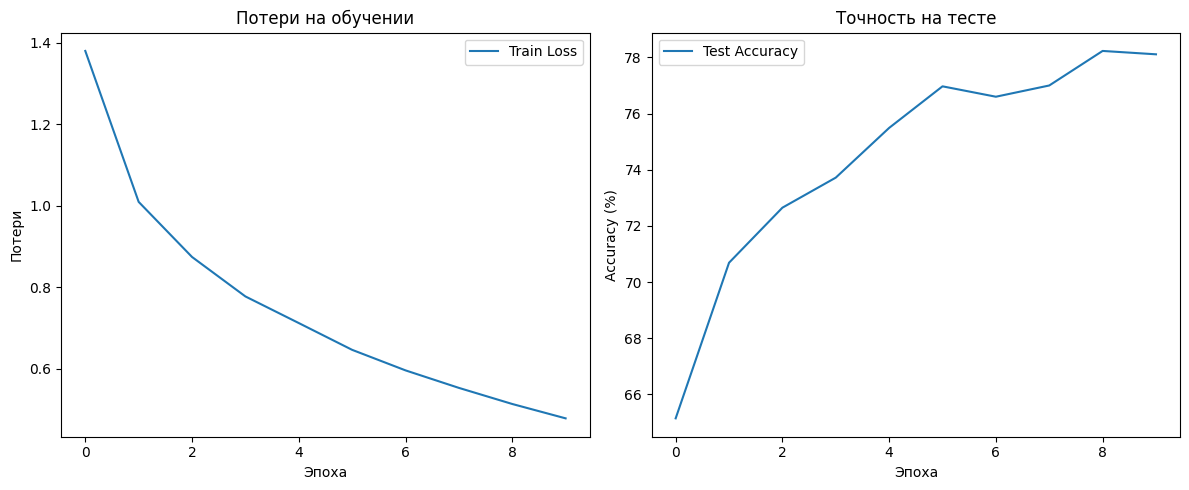

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Потери на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Точность на тесте')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

### 4. Dropout

пример 1

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.2)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
test_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f"Эпоха {epoch+1}/{num_epochs}, Потери на обучении: {train_losses[-1]:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Точность на тестовом наборе: {accuracy:.2f}%")

Эпоха 1/10, Потери на обучении: 1.2430
Точность на тестовом наборе: 65.52%
Эпоха 2/10, Потери на обучении: 0.9040
Точность на тестовом наборе: 68.67%
Эпоха 3/10, Потери на обучении: 0.7533
Точность на тестовом наборе: 71.35%
Эпоха 4/10, Потери на обучении: 0.6306
Точность на тестовом наборе: 72.07%
Эпоха 5/10, Потери на обучении: 0.5249
Точность на тестовом наборе: 72.91%
Эпоха 6/10, Потери на обучении: 0.4412
Точность на тестовом наборе: 72.45%
Эпоха 7/10, Потери на обучении: 0.3714
Точность на тестовом наборе: 72.76%
Эпоха 8/10, Потери на обучении: 0.3236
Точность на тестовом наборе: 72.43%
Эпоха 9/10, Потери на обучении: 0.2848
Точность на тестовом наборе: 72.36%
Эпоха 10/10, Потери на обучении: 0.2564
Точность на тестовом наборе: 72.09%


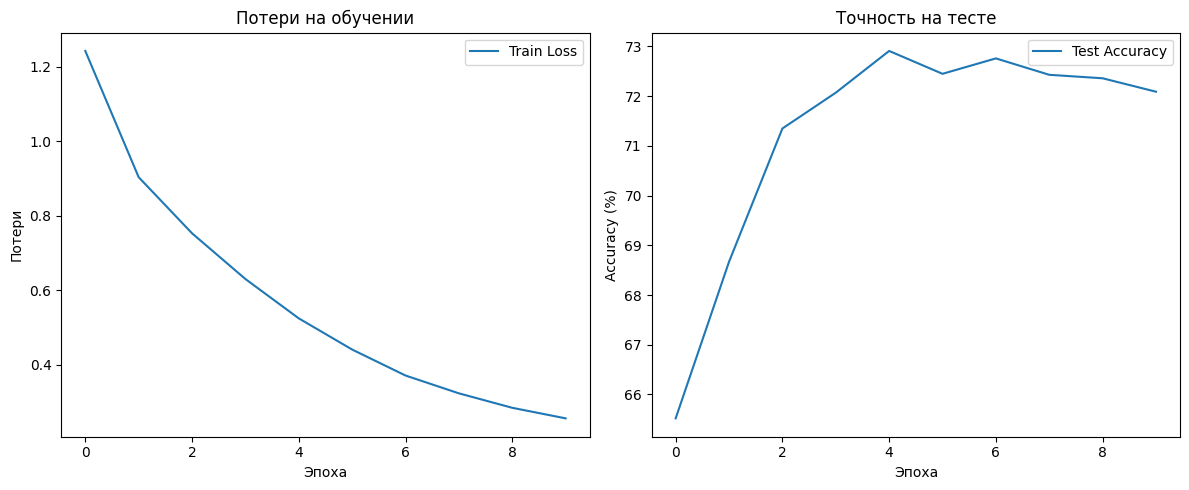

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Потери на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Точность на тесте')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

пример 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
test_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f"Эпоха {epoch+1}/{num_epochs}, Потери на обучении: {train_losses[-1]:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Точность на тестовом наборе: {accuracy:.2f}%")

Эпоха 1/10, Потери на обучении: 1.4570
Точность на тестовом наборе: 62.21%
Эпоха 2/10, Потери на обучении: 1.1167
Точность на тестовом наборе: 68.91%
Эпоха 3/10, Потери на обучении: 0.9673
Точность на тестовом наборе: 68.89%
Эпоха 4/10, Потери на обучении: 0.8734
Точность на тестовом наборе: 71.06%
Эпоха 5/10, Потери на обучении: 0.7998
Точность на тестовом наборе: 72.47%
Эпоха 6/10, Потери на обучении: 0.7395
Точность на тестовом наборе: 74.06%
Эпоха 7/10, Потери на обучении: 0.6851
Точность на тестовом наборе: 73.48%
Эпоха 8/10, Потери на обучении: 0.6396
Точность на тестовом наборе: 74.33%
Эпоха 9/10, Потери на обучении: 0.5963
Точность на тестовом наборе: 74.58%
Эпоха 10/10, Потери на обучении: 0.5565
Точность на тестовом наборе: 74.73%


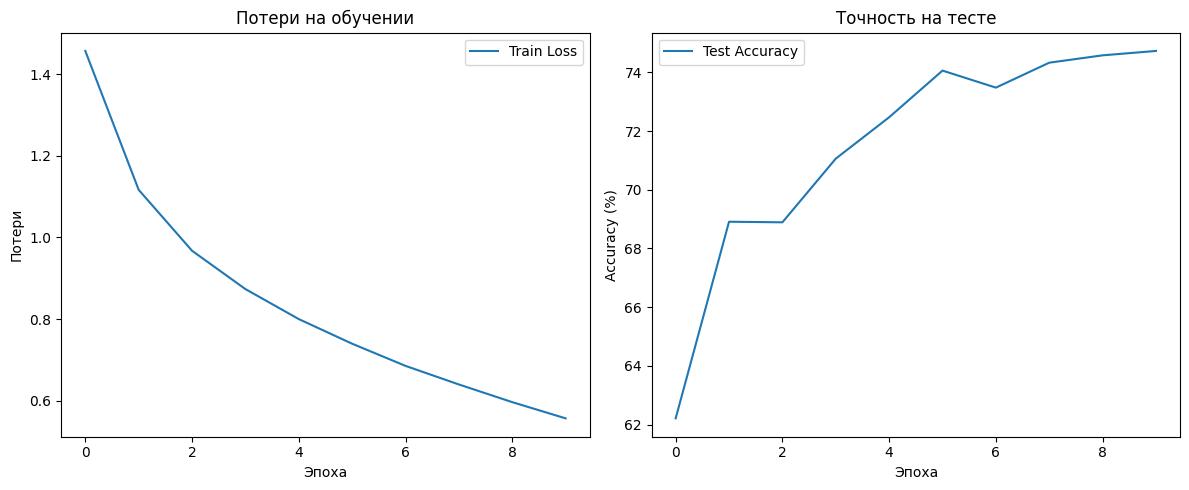

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Потери на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Точность на тесте')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

пример 3


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
test_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f"Эпоха {epoch+1}/{num_epochs}, Потери на обучении: {train_losses[-1]:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Точность на тестовом наборе: {accuracy:.2f}%")

Эпоха 1/10, Потери на обучении: 1.6181
Точность на тестовом наборе: 57.25%
Эпоха 2/10, Потери на обучении: 1.2659
Точность на тестовом наборе: 63.30%
Эпоха 3/10, Потери на обучении: 1.1315
Точность на тестовом наборе: 68.37%
Эпоха 4/10, Потери на обучении: 1.0419
Точность на тестовом наборе: 70.50%
Эпоха 5/10, Потери на обучении: 0.9722
Точность на тестовом наборе: 71.09%
Эпоха 6/10, Потери на обучении: 0.9169
Точность на тестовом наборе: 71.81%
Эпоха 7/10, Потери на обучении: 0.8677
Точность на тестовом наборе: 73.07%
Эпоха 8/10, Потери на обучении: 0.8266
Точность на тестовом наборе: 72.75%
Эпоха 9/10, Потери на обучении: 0.7963
Точность на тестовом наборе: 72.60%
Эпоха 10/10, Потери на обучении: 0.7605
Точность на тестовом наборе: 73.50%


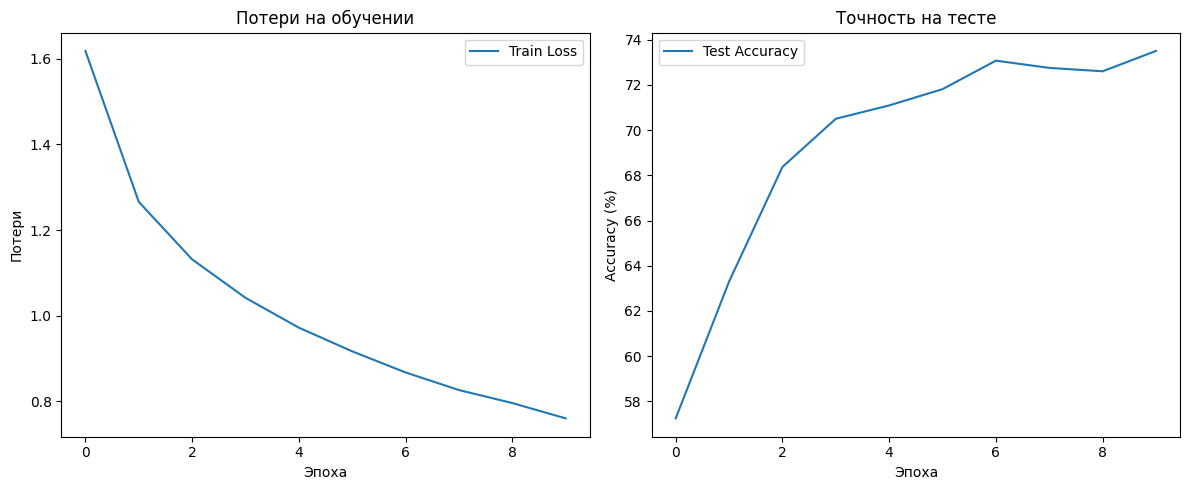

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Потери на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Точность на тесте')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

### 5. Полносвязные слои

пример 1

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    y_true, y_pred, y_pred_proba = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(probs.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(np.eye(10)[y_true], y_pred_proba, multi_class='ovr')

    print(f"\nЭпоха {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_losses[-1]:.4f}, Accuracy: {val_acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")


Эпоха 1/10
Train Loss: 1.6615, Accuracy: 39.68%
Val Loss: 1.4202, Accuracy: 49.99%
Precision: 0.5249, Recall: 0.4999, F1: 0.4955, ROC-AUC: 0.8889

Эпоха 2/10
Train Loss: 1.4146, Accuracy: 49.19%
Val Loss: 1.2417, Accuracy: 55.55%
Precision: 0.5613, Recall: 0.5555, F1: 0.5467, ROC-AUC: 0.9124

Эпоха 3/10
Train Loss: 1.3260, Accuracy: 52.69%
Val Loss: 1.1501, Accuracy: 59.88%
Precision: 0.5922, Recall: 0.5988, F1: 0.5931, ROC-AUC: 0.9235

Эпоха 4/10
Train Loss: 1.2772, Accuracy: 54.66%
Val Loss: 1.1255, Accuracy: 60.09%
Precision: 0.6074, Recall: 0.6009, F1: 0.5977, ROC-AUC: 0.9264

Эпоха 5/10
Train Loss: 1.2383, Accuracy: 56.33%
Val Loss: 1.1110, Accuracy: 60.88%
Precision: 0.6167, Recall: 0.6088, F1: 0.6022, ROC-AUC: 0.9303

Эпоха 6/10
Train Loss: 1.2133, Accuracy: 56.84%
Val Loss: 1.0591, Accuracy: 63.30%
Precision: 0.6350, Recall: 0.6330, F1: 0.6299, ROC-AUC: 0.9352

Эпоха 7/10
Train Loss: 1.1892, Accuracy: 57.84%
Val Loss: 1.1047, Accuracy: 60.11%
Precision: 0.6339, Recall: 0.6011,

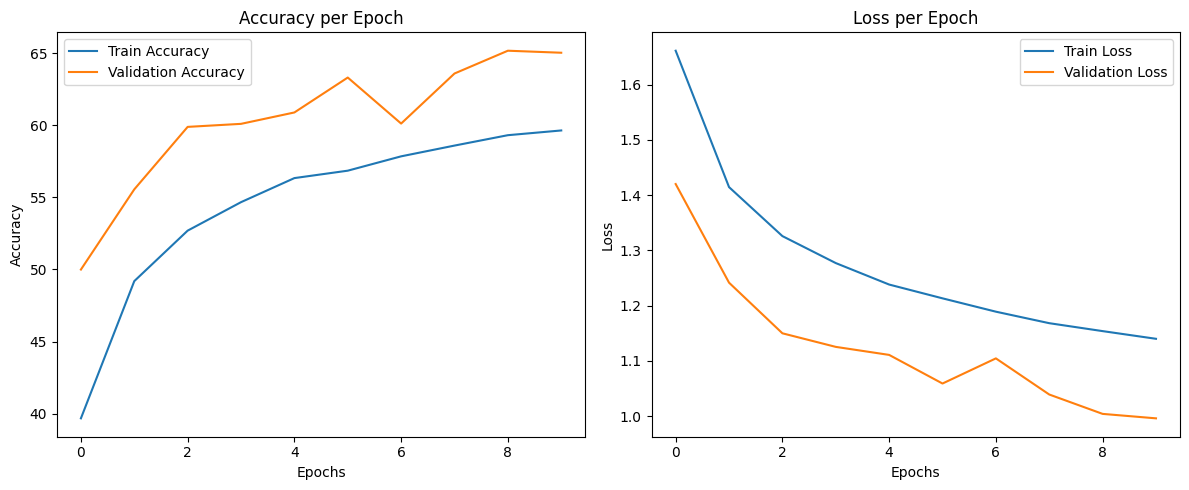

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs = range(len(train_acc))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses)

пример 2

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 100)  # 100 классов
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm1(torch.relu(self.conv2(x))))
        x = self.pool(self.batch_norm2(torch.relu(self.conv3(x))))
        x = self.adaptive_pool(x)  # [B, 128, 1, 1]
        x = x.view(x.size(0), -1)  # [B, 128]
        x = self.dropout(x)
        x = self.fc(x)  # [B, 100]
        return x

In [ ]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    y_true, y_pred, y_pred_proba = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(probs.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_epoch = val_loss / len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_acc)

    num_classes = y_pred_proba[0].shape[0]
    y_true_one_hot = np.eye(num_classes)[y_true]
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr')
    except ValueError:
        roc_auc = float('nan')

    print(f"\nЭпоха {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss_epoch:.4f}, Accuracy: {val_acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Эпоха 1/10
Train Loss: 1.4577, Accuracy: 47.99%
Val Loss: 1.1048, Accuracy: 60.73%
Precision: 0.6068, Recall: 0.6073, F1: 0.5993, ROC-AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Эпоха 2/10
Train Loss: 1.1019, Accuracy: 61.04%
Val Loss: 0.9050, Accuracy: 68.28%
Precision: 0.6790, Recall: 0.6828, F1: 0.6795, ROC-AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Эпоха 3/10
Train Loss: 0.9838, Accuracy: 65.69%
Val Loss: 0.8882, Accuracy: 69.36%
Precision: 0.6989, Recall: 0.6936, F1: 0.6911, ROC-AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Эпоха 4/10
Train Loss: 0.9035, Accuracy: 68.50%
Val Loss: 0.8190, Accuracy: 71.67%
Precision: 0.7215, Recall: 0.7167, F1: 0.7140, ROC-AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Эпоха 5/10
Train Loss: 0.8438, Accuracy: 70.61%
Val Loss: 0.7792, Accuracy: 72.77%
Precision: 0.7316, Recall: 0.7277, F1: 0.7262, ROC-AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Эпоха 6/10
Train Loss: 0.7994, Accuracy: 71.93%
Val Loss: 0.7264, Accuracy: 74.66%
Precision: 0.7452, Recall: 0.7466, F1: 0.7437, ROC-AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Эпоха 7/10
Train Loss: 0.7634, Accuracy: 73.34%
Val Loss: 0.7290, Accuracy: 74.80%
Precision: 0.7560, Recall: 0.7480, F1: 0.7480, ROC-AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Эпоха 8/10
Train Loss: 0.7306, Accuracy: 74.51%
Val Loss: 0.7187, Accuracy: 74.87%
Precision: 0.7578, Recall: 0.7487, F1: 0.7450, ROC-AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



Эпоха 9/10
Train Loss: 0.7018, Accuracy: 75.49%
Val Loss: 0.7445, Accuracy: 74.72%
Precision: 0.7576, Recall: 0.7472, F1: 0.7449, ROC-AUC: nan

Эпоха 10/10
Train Loss: 0.6845, Accuracy: 76.49%
Val Loss: 0.6757, Accuracy: 76.58%
Precision: 0.7677, Recall: 0.7658, F1: 0.7649, ROC-AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


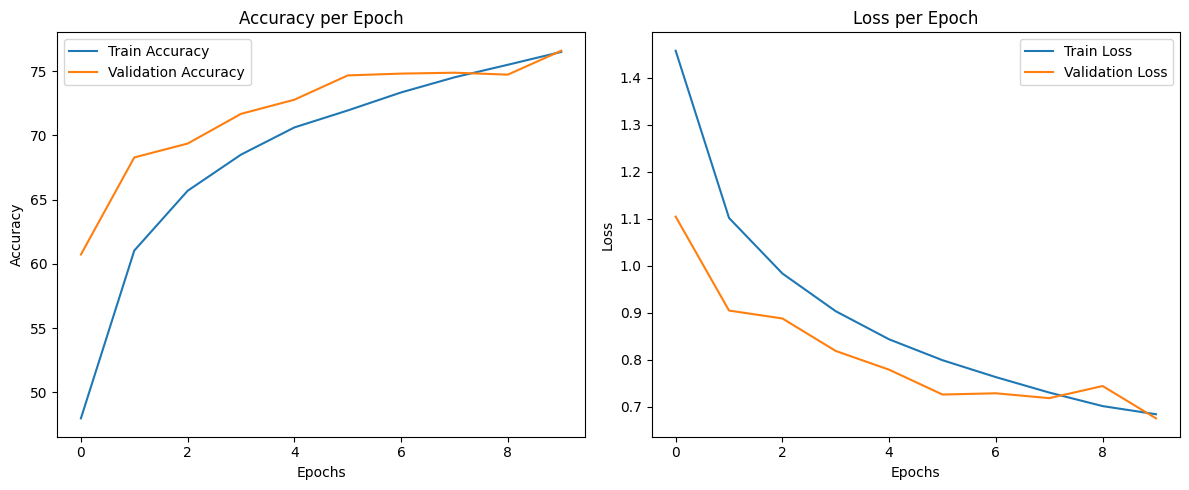

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs = range(len(train_acc))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses)

пример 3

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm1(torch.relu(self.conv2(x))))
        x = self.pool(self.batch_norm2(torch.relu(self.conv3(x))))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    y_true, y_pred, y_pred_proba = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(probs.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_epoch = val_loss / len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_acc)

    num_classes = y_pred_proba[0].shape[0]
    y_true_one_hot = np.eye(num_classes)[y_true]
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr')
    except ValueError:
        roc_auc = float('nan')

    print(f"\nЭпоха {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss_epoch:.4f}, Accuracy: {val_acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")


Эпоха 1/10
Train Loss: 1.4136, Accuracy: 48.22%
Val Loss: 1.1217, Accuracy: 58.83%
Precision: 0.6075, Recall: 0.5883, F1: 0.5778, ROC-AUC: 0.9299

Эпоха 2/10
Train Loss: 1.1024, Accuracy: 60.49%
Val Loss: 0.9374, Accuracy: 66.19%
Precision: 0.6649, Recall: 0.6619, F1: 0.6595, ROC-AUC: 0.9470

Эпоха 3/10
Train Loss: 0.9783, Accuracy: 65.46%
Val Loss: 0.8896, Accuracy: 68.41%
Precision: 0.6988, Recall: 0.6841, F1: 0.6830, ROC-AUC: 0.9541

Эпоха 4/10
Train Loss: 0.9072, Accuracy: 68.00%
Val Loss: 0.8054, Accuracy: 71.37%
Precision: 0.7180, Recall: 0.7137, F1: 0.7107, ROC-AUC: 0.9616

Эпоха 5/10
Train Loss: 0.8475, Accuracy: 69.95%
Val Loss: 0.7494, Accuracy: 73.53%
Precision: 0.7364, Recall: 0.7353, F1: 0.7336, ROC-AUC: 0.9654

Эпоха 6/10
Train Loss: 0.7982, Accuracy: 71.83%
Val Loss: 0.7338, Accuracy: 74.06%
Precision: 0.7466, Recall: 0.7406, F1: 0.7408, ROC-AUC: 0.9668

Эпоха 7/10
Train Loss: 0.7610, Accuracy: 73.18%
Val Loss: 0.7220, Accuracy: 74.62%
Precision: 0.7485, Recall: 0.7462,

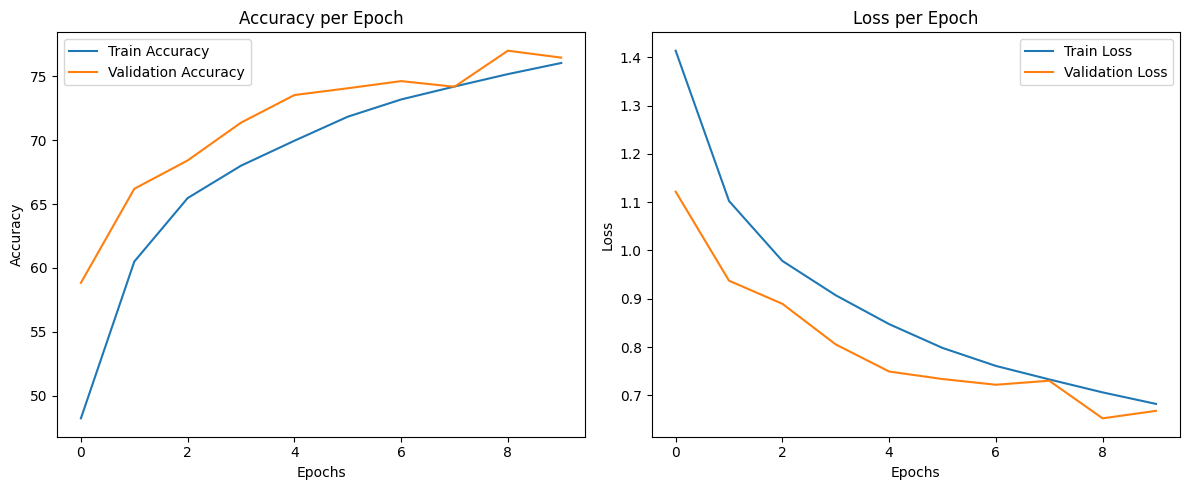

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs = range(len(train_acc))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses)

## Часть 4: Оптимизация гиперпараметров с использованием нестандартных методов

### 1. Learning Rate (Темп обучения)

Использование Cyclic Learning Rate

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=5, mode='triangular')

num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
lr_history = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        lr_history.append(optimizer.param_groups[0]['lr'])

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    y_true, y_pred, y_pred_proba = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(probs.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_epoch = val_loss / len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_acc)

    y_true_one_hot = np.eye(10)[y_true]
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr')
    except ValueError:
        roc_auc = float('nan')

    print(f"\nЭпоха {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss_epoch:.4f}, Accuracy: {val_acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")


Эпоха 1/10
Train Loss: 1.7233, Accuracy: 36.78%
Val Loss: 1.4854, Accuracy: 46.06%
Precision: 0.4731, Recall: 0.4606, F1: 0.4441, ROC-AUC: 0.8774

Эпоха 2/10
Train Loss: 1.5081, Accuracy: 45.03%
Val Loss: 1.3629, Accuracy: 52.11%
Precision: 0.5405, Recall: 0.5211, F1: 0.5154, ROC-AUC: 0.8984

Эпоха 3/10
Train Loss: 1.4178, Accuracy: 49.05%
Val Loss: 1.3098, Accuracy: 52.66%
Precision: 0.5550, Recall: 0.5266, F1: 0.5226, ROC-AUC: 0.9064

Эпоха 4/10
Train Loss: 1.3533, Accuracy: 51.77%
Val Loss: 1.1931, Accuracy: 57.90%
Precision: 0.5895, Recall: 0.5790, F1: 0.5793, ROC-AUC: 0.9195

Эпоха 5/10
Train Loss: 1.3191, Accuracy: 52.88%
Val Loss: 1.1589, Accuracy: 59.63%
Precision: 0.5941, Recall: 0.5963, F1: 0.5873, ROC-AUC: 0.9234

Эпоха 6/10
Train Loss: 1.2922, Accuracy: 53.69%
Val Loss: 1.1483, Accuracy: 59.17%
Precision: 0.5947, Recall: 0.5917, F1: 0.5838, ROC-AUC: 0.9241

Эпоха 7/10
Train Loss: 1.2551, Accuracy: 55.30%
Val Loss: 1.1241, Accuracy: 60.54%
Precision: 0.6110, Recall: 0.6054,

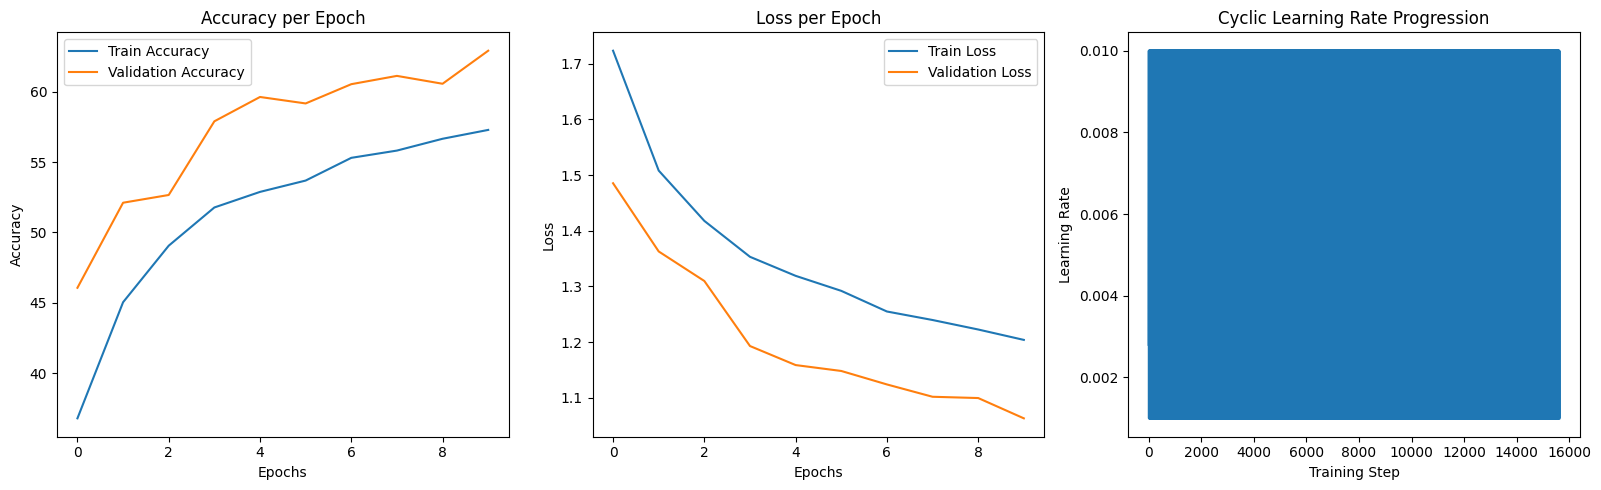

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss, lr_history):
    epochs = range(len(train_acc))
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(lr_history)
    plt.xlabel('Training Step')
    plt.ylabel('Learning Rate')
    plt.title('Cyclic Learning Rate Progression')

    plt.tight_layout()
    plt.show()

plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses, lr_history)

Исследование адаптивного learning rate с Adam

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    y_true, y_pred, y_pred_proba = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(probs.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_epoch = val_loss / len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_acc)

    y_true_one_hot = np.eye(10)[y_true]
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr')
    except ValueError:
        roc_auc = float('nan')

    print(f"\nЭпоха {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss_epoch:.4f}, Accuracy: {val_acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")


Эпоха 1/10
Train Loss: 1.6756, Accuracy: 38.92%
Val Loss: 1.4188, Accuracy: 49.14%
Precision: 0.4968, Recall: 0.4914, F1: 0.4739, ROC-AUC: 0.8885

Эпоха 2/10
Train Loss: 1.4186, Accuracy: 49.03%
Val Loss: 1.2598, Accuracy: 55.76%
Precision: 0.5709, Recall: 0.5576, F1: 0.5603, ROC-AUC: 0.9105

Эпоха 3/10
Train Loss: 1.3304, Accuracy: 52.72%
Val Loss: 1.2028, Accuracy: 57.69%
Precision: 0.5972, Recall: 0.5769, F1: 0.5760, ROC-AUC: 0.9191

Эпоха 4/10
Train Loss: 1.2869, Accuracy: 54.44%
Val Loss: 1.1418, Accuracy: 60.61%
Precision: 0.6117, Recall: 0.6061, F1: 0.6037, ROC-AUC: 0.9261

Эпоха 5/10
Train Loss: 1.2485, Accuracy: 55.79%
Val Loss: 1.1393, Accuracy: 60.02%
Precision: 0.6157, Recall: 0.6002, F1: 0.6024, ROC-AUC: 0.9245

Эпоха 6/10
Train Loss: 1.2219, Accuracy: 56.38%
Val Loss: 1.0816, Accuracy: 61.97%
Precision: 0.6176, Recall: 0.6197, F1: 0.6122, ROC-AUC: 0.9322

Эпоха 7/10
Train Loss: 1.1943, Accuracy: 57.76%
Val Loss: 1.0592, Accuracy: 63.47%
Precision: 0.6385, Recall: 0.6347,

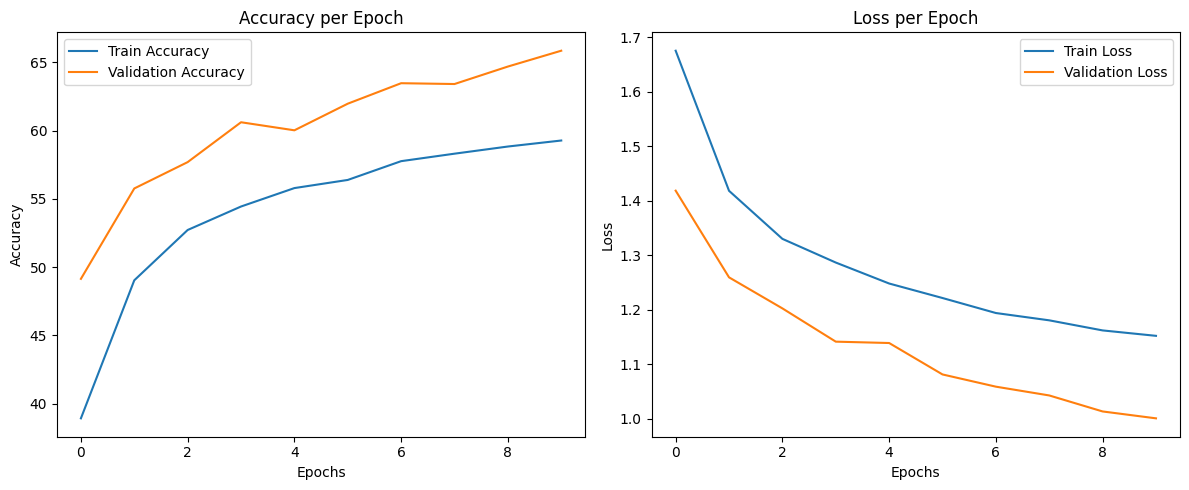

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs = range(len(train_acc))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses)

### 2. Batch Size (Размер пакета)

Динамическое изменение Batch Size

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
initial_batch_size = 32
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
for epoch in range(num_epochs):
    if epoch % 5 == 0:
        current_batch_size = initial_batch_size * (epoch // 5 + 1)
        train_loader = DataLoader(train_data, batch_size=current_batch_size, shuffle=True)
        print(f"\n[INFO] Epoch {epoch+1}: Batch size изменён на {current_batch_size}")

    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    y_true, y_pred, y_pred_proba = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(probs.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_epoch = val_loss / len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_acc)

    y_true_one_hot = np.eye(10)[y_true]
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr')
    except ValueError:
        roc_auc = float('nan')

    print(f"\nЭпоха {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss_epoch:.4f}, Accuracy: {val_acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")


[INFO] Epoch 1: Batch size изменён на 32

Эпоха 1/15
Train Loss: 1.6915, Accuracy: 38.12%
Val Loss: 1.4467, Accuracy: 48.97%
Precision: 0.5088, Recall: 0.4897, F1: 0.4819, ROC-AUC: 0.8854

Эпоха 2/15
Train Loss: 1.4383, Accuracy: 48.33%
Val Loss: 1.3093, Accuracy: 53.51%
Precision: 0.5324, Recall: 0.5351, F1: 0.5200, ROC-AUC: 0.9051

Эпоха 3/15
Train Loss: 1.3422, Accuracy: 51.74%
Val Loss: 1.1794, Accuracy: 58.36%
Precision: 0.5822, Recall: 0.5836, F1: 0.5782, ROC-AUC: 0.9195

Эпоха 4/15
Train Loss: 1.2879, Accuracy: 54.13%
Val Loss: 1.1640, Accuracy: 59.56%
Precision: 0.5992, Recall: 0.5956, F1: 0.5933, ROC-AUC: 0.9222

Эпоха 5/15
Train Loss: 1.2574, Accuracy: 55.25%
Val Loss: 1.1257, Accuracy: 60.95%
Precision: 0.6161, Recall: 0.6095, F1: 0.6052, ROC-AUC: 0.9277

[INFO] Epoch 6: Batch size изменён на 64

Эпоха 6/15
Train Loss: 1.1908, Accuracy: 57.86%
Val Loss: 1.0666, Accuracy: 62.34%
Precision: 0.6333, Recall: 0.6234, F1: 0.6238, ROC-AUC: 0.9335

Эпоха 7/15
Train Loss: 1.1764, Ac

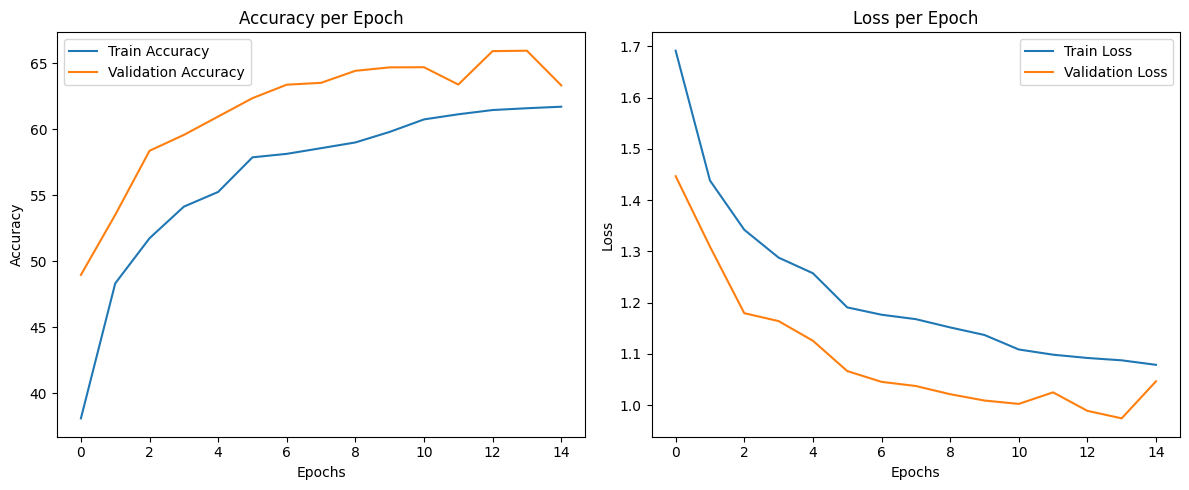

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs = range(len(train_acc))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses)

Gradient Accumulation

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15
accumulation_steps = 4

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    optimizer.zero_grad()

    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    y_true, y_pred, y_pred_proba = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(probs.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_epoch = val_loss / len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_acc)

    y_true_one_hot = np.eye(10)[y_true]
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr')
    except ValueError:
        roc_auc = float('nan')

    print(f"\nЭпоха {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss_epoch:.4f}, Accuracy: {val_acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")


Эпоха 1/15
Train Loss: 1.7759, Accuracy: 34.94%
Val Loss: 1.5007, Accuracy: 47.20%
Precision: 0.4690, Recall: 0.4720, F1: 0.4657, ROC-AUC: 0.8729

Эпоха 2/15
Train Loss: 1.5112, Accuracy: 45.82%
Val Loss: 1.3643, Accuracy: 52.15%
Precision: 0.5274, Recall: 0.5215, F1: 0.5163, ROC-AUC: 0.8967

Эпоха 3/15
Train Loss: 1.4004, Accuracy: 49.98%
Val Loss: 1.2617, Accuracy: 55.69%
Precision: 0.5616, Recall: 0.5569, F1: 0.5504, ROC-AUC: 0.9100

Эпоха 4/15
Train Loss: 1.3402, Accuracy: 52.32%
Val Loss: 1.2139, Accuracy: 57.45%
Precision: 0.5729, Recall: 0.5745, F1: 0.5688, ROC-AUC: 0.9157

Эпоха 5/15
Train Loss: 1.2920, Accuracy: 54.09%
Val Loss: 1.1666, Accuracy: 58.48%
Precision: 0.5823, Recall: 0.5848, F1: 0.5792, ROC-AUC: 0.9212

Эпоха 6/15
Train Loss: 1.2586, Accuracy: 55.18%
Val Loss: 1.1395, Accuracy: 59.46%
Precision: 0.6014, Recall: 0.5946, F1: 0.5896, ROC-AUC: 0.9262

Эпоха 7/15
Train Loss: 1.2312, Accuracy: 56.24%
Val Loss: 1.0938, Accuracy: 61.73%
Precision: 0.6151, Recall: 0.6173,

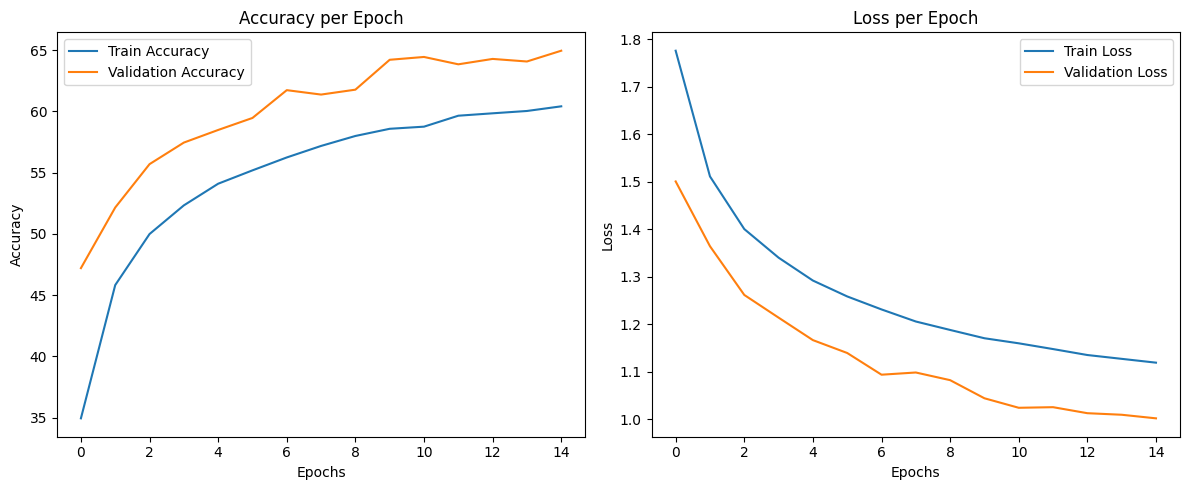

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs = range(len(train_acc))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses)

### 3. Количество фильтров и слоев

Progressive Layer Growth

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 16 * 16)
        x = self.fc1(x)
        return x

class ExtendedCNN(SimpleCNN):
    def __init__(self):
        super(ExtendedCNN, self).__init__()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc2 = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc2(x)
        return x

In [ ]:
def train_model():
    num_epochs = 20
    switch_epoch = 10
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model = SimpleCNN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        if epoch == switch_epoch:
            print("Расширение модели после 10 эпох")
            new_model = ExtendedCNN()
            new_model.conv1.load_state_dict(model.conv1.state_dict())
            new_model.fc2.weight.data.copy_(model.fc1.weight.data[:, :32*8*8])
            new_model.fc2.bias.data.copy_(model.fc1.bias.data)
            model = new_model
            optimizer = optim.Adam(model.parameters(), lr=0.001)

        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        y_true, y_pred, y_pred_proba = [], [], []

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                probs = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probs, 1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                y_pred_proba.extend(probs.cpu().numpy())

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss_epoch = val_loss / len(test_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss_epoch)
        val_accuracies.append(val_acc)

        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        try:
            roc_auc = roc_auc_score(np.eye(10)[y_true], y_pred_proba, multi_class='ovr')
        except ValueError:
            roc_auc = float('nan')

        print(f"\nЭпоха {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss_epoch:.4f}, Accuracy: {val_acc:.2f}%")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

    return train_accuracies, val_accuracies, train_losses, val_losses

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs = range(len(train_acc))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


Эпоха 1/20
Train Loss: 1.4608, Accuracy: 48.63%
Val Loss: 1.2813, Accuracy: 55.04%
Precision: 0.5565, Recall: 0.5504, F1: 0.5465, ROC-AUC: 0.9051

Эпоха 2/20
Train Loss: 1.2000, Accuracy: 58.38%
Val Loss: 1.1822, Accuracy: 59.08%
Precision: 0.5958, Recall: 0.5908, F1: 0.5868, ROC-AUC: 0.9194

Эпоха 3/20
Train Loss: 1.1040, Accuracy: 61.68%
Val Loss: 1.1346, Accuracy: 60.67%
Precision: 0.6134, Recall: 0.6067, F1: 0.6004, ROC-AUC: 0.9258

Эпоха 4/20
Train Loss: 1.0372, Accuracy: 64.29%
Val Loss: 1.1413, Accuracy: 60.30%
Precision: 0.6327, Recall: 0.6030, F1: 0.5912, ROC-AUC: 0.9282

Эпоха 5/20
Train Loss: 0.9960, Accuracy: 65.67%
Val Loss: 1.0978, Accuracy: 62.06%
Precision: 0.6353, Recall: 0.6206, F1: 0.6210, ROC-AUC: 0.9306

Эпоха 6/20
Train Loss: 0.9558, Accuracy: 67.06%
Val Loss: 1.0802, Accuracy: 63.23%
Precision: 0.6381, Recall: 0.6323, F1: 0.6270, ROC-AUC: 0.9324

Эпоха 7/20
Train Loss: 0.9272, Accuracy: 68.10%
Val Loss: 1.0675, Accuracy: 63.50%
Precision: 0.6402, Recall: 0.6350,

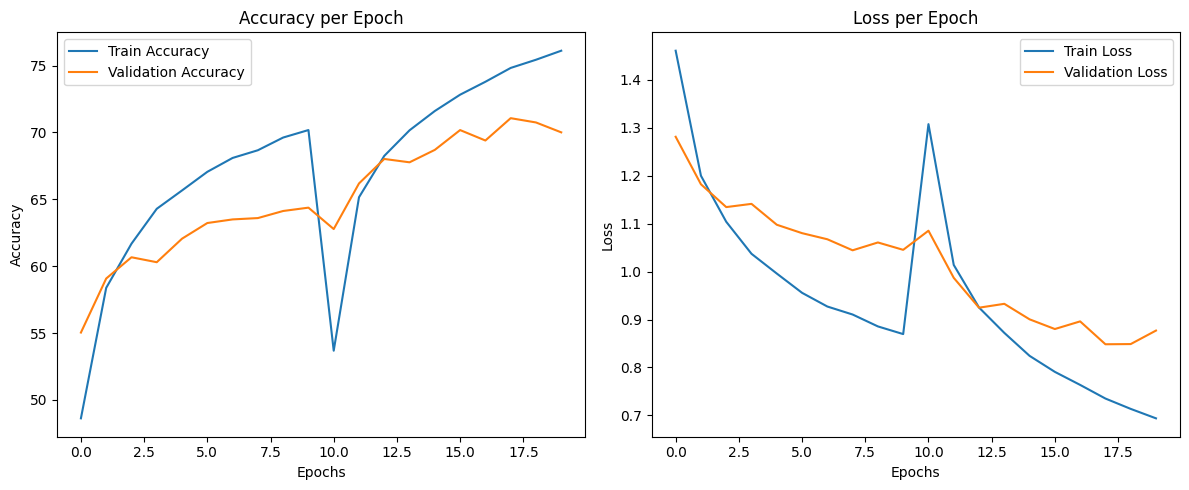

In [ ]:
train_acc, val_acc, train_loss, val_loss = train_model()
plot_metrics(train_acc, val_acc, train_loss, val_loss)

Random Filter Pruning

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        return x

def prune_filters(model, threshold=0.2):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name and param.dim() > 1:
                dropout_mask = F.dropout(torch.ones_like(param.data), p=threshold)
                param.data *= dropout_mask
    print(f"Применён pruning с threshold={threshold}")

In [ ]:
def train_model(model, prune_threshold=0.2, num_epochs=15):
    prune_filters(model, threshold=prune_threshold)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        y_true, y_pred, y_pred_proba = [], [], []

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                probs = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probs, 1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                y_pred_proba.extend(probs.cpu().numpy())

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss_epoch = val_loss / len(test_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss_epoch)
        val_accuracies.append(val_acc)

        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        try:
            roc_auc = roc_auc_score(np.eye(10)[y_true], y_pred_proba, multi_class='ovr')
        except ValueError:
            roc_auc = float('nan')

        print(f"\nЭпоха {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss_epoch:.4f}, Accuracy: {val_acc:.2f}%")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

    return train_accuracies, val_accuracies, train_losses, val_losses

In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs = range(len(train_acc))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

Применён pruning с threshold=0.2

Эпоха 1/15
Train Loss: 1.3425, Accuracy: 52.50%
Val Loss: 1.1187, Accuracy: 60.29%
Precision: 0.6177, Recall: 0.6029, F1: 0.5936, ROC-AUC: 0.9299

Эпоха 2/15
Train Loss: 0.9917, Accuracy: 65.68%
Val Loss: 0.9256, Accuracy: 68.20%
Precision: 0.6832, Recall: 0.6820, F1: 0.6812, ROC-AUC: 0.9479

Эпоха 3/15
Train Loss: 0.8576, Accuracy: 70.32%
Val Loss: 0.9065, Accuracy: 68.83%
Precision: 0.6883, Recall: 0.6883, F1: 0.6813, ROC-AUC: 0.9525

Эпоха 4/15
Train Loss: 0.7813, Accuracy: 73.00%
Val Loss: 0.8739, Accuracy: 70.14%
Precision: 0.7035, Recall: 0.7014, F1: 0.7000, ROC-AUC: 0.9541

Эпоха 5/15
Train Loss: 0.7238, Accuracy: 75.06%
Val Loss: 0.8722, Accuracy: 70.01%
Precision: 0.7241, Recall: 0.7001, F1: 0.7032, ROC-AUC: 0.9573

Эпоха 6/15
Train Loss: 0.6675, Accuracy: 76.92%
Val Loss: 0.8496, Accuracy: 71.12%
Precision: 0.7208, Recall: 0.7112, F1: 0.7113, ROC-AUC: 0.9581

Эпоха 7/15
Train Loss: 0.6220, Accuracy: 78.62%
Val Loss: 0.8288, Accuracy: 71.76%
P

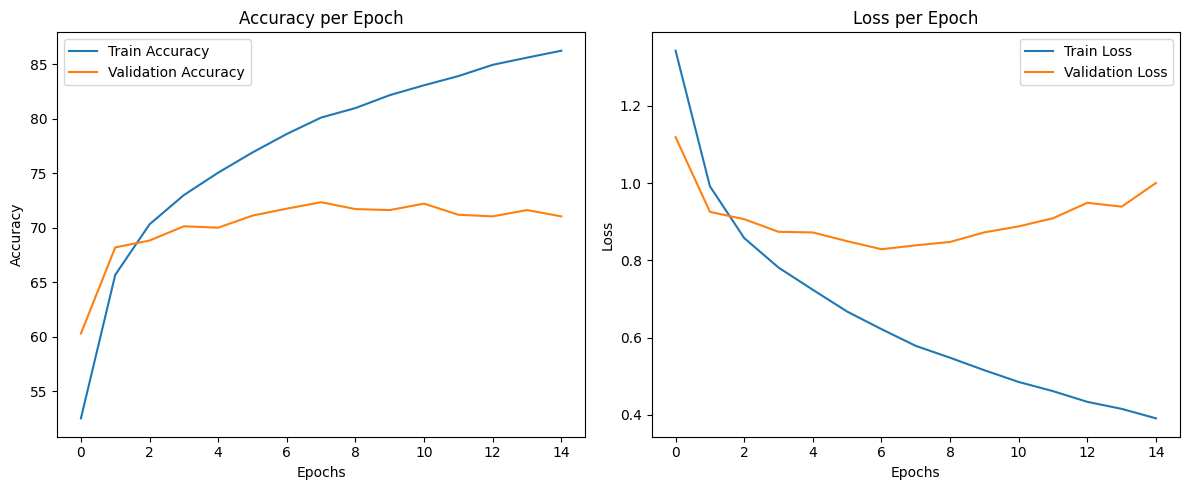

In [ ]:
model = SimpleCNN()
train_acc, val_acc, train_loss, val_loss = train_model(model, prune_threshold=0.2)
plot_metrics(train_acc, val_acc, train_loss, val_loss)